# Setup
This is the `full` notebook containing all the code required for training the model accross all possible configurations (1-/5-shot, w/ w/out PAR, diff. annotations, etc.). Its recommended to view the `PANET_main` notebook before going through this as it provides more insight into the pipeline that we're using below.

In [6]:
# @title Init Project Code, Imports, and Constants
!pip install torch-summary
!pip install torchinfo

!git init
!git remote add origin https://github.com/bryjen/PANet
!git fetch
!git reset --hard origin/master

!pip install sacred

import os
import tqdm
import torch
import shutil
import zipfile
import kagglehub
import torch.optim

import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn

from google.colab import drive
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

from models.fewshot import FewShotSeg
from dataloaders.customized import voc_fewshot, coco_fewshot
from dataloaders.transforms import ToTensorNormalize
from dataloaders.transforms import Resize, DilateScribble
from util.metric import Metric
from util.utils import set_seed, CLASS_LABELS, get_bbox
from config import ex


DRIVE_MOUNTED = False

Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
HEAD is now at bf60b2c Fixes training loss tracker


In [3]:
# @title Pre-trained and Weights & Dataset augmentation files
# Here we download files required to setup the pipeline.
# We download pre-trained weights so that we can fine-tune the model.
# Additionally, we download additional annotations (scribbles + bounding boxes)
# and modify the downloaded dataset with these files.

# pre-trained weights
os.makedirs("/content/pretrained_model/", exist_ok=True)
!gdown 1TJZy_YkYwNMkdtECAlkWy8VuorPFjP1t --output "/content/pretrained_model/"

# dataset modification files
os.makedirs("/content/dataset_augmentations/", exist_ok=True)
!gdown 1ZP6FHiclSNk1nH0WxhCH-W_fwd3GnEZa --output "/content/dataset_augmentations/"
!gdown 1oGy-tg_Tv_-ZUQeiNtM5i4sK0lYB0MeL --output "/content/dataset_augmentations/"
!gdown 1R5G3BfQTAY4zWkazTsgFc3kJNQVjwi4M --output "/content/dataset_augmentations/"
!gdown 1D4oX0Ub6ObFO81yonWY4ehZ-tr5Hn5UK --output "/content/dataset_augmentations/"


path = kagglehub.dataset_download("ngan2710/voc-devkit-2007-and-2012")

scribble_aug_auto_zip_path = "/content/dataset_augmentations/ScribbleAugAuto.zip"
segmentation_class_aug_zip_path = "/content/dataset_augmentations/SegmentationClassAug.zip"
segmentation_object_aug_zip_path = "/content/dataset_augmentations/SegmentationObjectAug.zip"

extract_to = "/root/.cache/kagglehub/datasets/ngan2710/voc-devkit-2007-and-2012/versions/1/VOCdevkit/VOC2012/"

with zipfile.ZipFile(scribble_aug_auto_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

with zipfile.ZipFile(segmentation_class_aug_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

with zipfile.ZipFile(segmentation_object_aug_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


segmentation_replacement_zip_path = "/content/dataset_augmentations/Segmentation.zip"
imagesets_dir = "/root/.cache/kagglehub/datasets/ngan2710/voc-devkit-2007-and-2012/versions/1/VOCdevkit/VOC2012/ImageSets/"

shutil.rmtree(f"{imagesets_dir}Segmentation", ignore_errors=True)

with zipfile.ZipFile(segmentation_replacement_zip_path, 'r') as zip_ref:
    zip_ref.extractall(imagesets_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1TJZy_YkYwNMkdtECAlkWy8VuorPFjP1t
From (redirected): https://drive.google.com/uc?id=1TJZy_YkYwNMkdtECAlkWy8VuorPFjP1t&confirm=t&uuid=b9a9da3f-a122-4bcc-a4f4-991e7edb454d
To: /content/pretrained_model/vgg16-397923af.pth
100% 553M/553M [00:02<00:00, 271MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ZP6FHiclSNk1nH0WxhCH-W_fwd3GnEZa
From (redirected): https://drive.google.com/uc?id=1ZP6FHiclSNk1nH0WxhCH-W_fwd3GnEZa&confirm=t&uuid=8f7ff6ab-06c8-4e45-9707-22fa8fba4c75
To: /content/dataset_augmentations/ScribbleAugAuto.zip
100% 40.5M/40.5M [00:01<00:00, 33.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oGy-tg_Tv_-ZUQeiNtM5i4sK0lYB0MeL
To: /content/dataset_augmentations/Segmentation.zip
100% 137k/137k [00:00<00:00, 76.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1R5G3BfQTAY4zWkazTsgFc3kJNQVjwi4M
From (redirected): https://drive.google.com/uc?id=1R5G3BfQTAY4zWkazTsgFc3kJNQ

100%|██████████| 2.23G/2.23G [01:42<00:00, 23.3MB/s]

Extracting files...


# Training and Testing

In [7]:
os.chdir("/content/")

# recommended to save to drive so that progress can be saved between training/testing blocks
if DRIVE_MOUNTED is False:
  drive.mount('/content/drive')
  DRIVE_MOUNTED = True

Mounted at /content/drive


****

In [ ]:
# VOC 1-way 1-shot; TRAIN
!python train.py with mode='train' dataset='VOC' label_sets=0 model.align=False task.n_ways=1 task.n_shots=1
!python train.py with mode='train' dataset='VOC' label_sets=1 model.align=False task.n_ways=1 task.n_shots=1
!python train.py with mode='train' dataset='VOC' label_sets=2 model.align=False task.n_ways=1 task.n_shots=1
!python train.py with mode='train' dataset='VOC' label_sets=3 model.align=False task.n_ways=1 task.n_shots=1

In [ ]:
# VOC 1-way 1-shot; TEST
!python test.py with mode='test' snapshot='./runs/PANet_VOC_sets_0_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_sets_1_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_sets_2_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_sets_3_1way_1shot_[train]/1/snapshots/30000.pth'

In [ ]:
if DRIVE_MOUNTED is True:
  src = "/content/runs/"
  dst = "/content/drive/MyDrive/PANet/Results/"
  shutil.copytree(src, dst, dirs_exist_ok=True)
  final_model_weights = "/content/drive/MyDrive/PANet/Results/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth"

****

In [ ]:
# VOC 1-way 5-shot; TRAIN
!python train.py with mode='train' dataset='VOC' label_sets=0 model.align=False task.n_ways=1 task.n_shots=5
!python train.py with mode='train' dataset='VOC' label_sets=1 model.align=False task.n_ways=1 task.n_shots=5
!python train.py with mode='train' dataset='VOC' label_sets=2 model.align=False task.n_ways=1 task.n_shots=5
!python train.py with mode='train' dataset='VOC' label_sets=3 model.align=False task.n_ways=1 task.n_shots=5

In [ ]:
# VOC 1-way 5-shot; TEST
!python test.py with mode='test' snapshot='./runs/PANet_VOC_sets_0_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_sets_1_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_sets_2_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_sets_3_1way_5shot_[train]/1/snapshots/30000.pth'

In [ ]:
if DRIVE_MOUNTED is True:
  src = "/content/runs/"
  dst = "/content/drive/MyDrive/PANet/Results/"
  shutil.copytree(src, dst, dirs_exist_ok=True)
  final_model_weights = "/content/drive/MyDrive/PANet/Results/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth"

****

In [ ]:
# VOC 1-way 1-shot; PAR; TRAIN
!python train.py with mode='train' dataset='VOC' label_sets=0 model.align=True task.n_ways=1 task.n_shots=1
!python train.py with mode='train' dataset='VOC' label_sets=1 model.align=True task.n_ways=1 task.n_shots=1
!python train.py with mode='train' dataset='VOC' label_sets=2 model.align=True task.n_ways=1 task.n_shots=1
!python train.py with mode='train' dataset='VOC' label_sets=3 model.align=True task.n_ways=1 task.n_shots=1

In [ ]:
# VOC 1-way 1-shot; PAR; TEST
!python test.py with mode='test' snapshot='./runs/PANet_VOC_align_sets_0_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_align_sets_1_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_align_sets_2_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_align_sets_3_1way_1shot_[train]/1/snapshots/30000.pth'

In [ ]:
if DRIVE_MOUNTED is True:
  src = "/content/runs/"
  dst = "/content/drive/MyDrive/PANet/Results/"
  shutil.copytree(src, dst, dirs_exist_ok=True)
  final_model_weights = "/content/drive/MyDrive/PANet/Results/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth"

****

In [ ]:
# VOC 1-way 5-shot; PAR; TRAIN
!python train.py with mode='train' dataset='VOC' label_sets=0 model.align=True task.n_ways=1 task.n_shots=5
!python train.py with mode='train' dataset='VOC' label_sets=1 model.align=True task.n_ways=1 task.n_shots=5
!python train.py with mode='train' dataset='VOC' label_sets=2 model.align=True task.n_ways=1 task.n_shots=5
!python train.py with mode='train' dataset='VOC' label_sets=3 model.align=True task.n_ways=1 task.n_shots=5

In [ ]:
# VOC 1-way 5-shot; PAR; TEST
!python test.py with mode='test' snapshot='./runs/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_align_sets_1_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_align_sets_2_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' snapshot='./runs/PANet_VOC_align_sets_3_1way_5shot_[train]/1/snapshots/30000.pth'

In [ ]:
if DRIVE_MOUNTED is True:
  src = "/content/runs/"
  dst = "/content/drive/MyDrive/PANet/Results/"
  shutil.copytree(src, dst, dirs_exist_ok=True)
  final_model_weights = "/content/drive/MyDrive/PANet/Results/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth"

****

In [ ]:
# VOC 1-way 1-shot; PAR; BBOX ANNOTATIONS; TEST
!python test.py with mode='test' bbox=True snapshot='./runs/PANet_VOC_align_sets_0_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' bbox=True snapshot='./runs/PANet_VOC_align_sets_1_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' bbox=True snapshot='./runs/PANet_VOC_align_sets_2_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' bbox=True snapshot='./runs/PANet_VOC_align_sets_3_1way_1shot_[train]/1/snapshots/30000.pth'

In [ ]:
# VOC 1-way 5-shot; PAR; BBOX ANNOTATIONS; TEST
!python test.py with mode='test' bbox=True snapshot='./runs/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' bbox=True snapshot='./runs/PANet_VOC_align_sets_1_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' bbox=True snapshot='./runs/PANet_VOC_align_sets_2_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' bbox=True snapshot='./runs/PANet_VOC_align_sets_3_1way_5shot_[train]/1/snapshots/30000.pth'

****

In [ ]:
# VOC 1-way 1-shot; PAR; SCRIBBLE ANNOTATIONS; TEST
!python test.py with mode='test' scribble=True snapshot='./runs/PANet_VOC_align_sets_0_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' scribble=True snapshot='./runs/PANet_VOC_align_sets_1_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' scribble=True snapshot='./runs/PANet_VOC_align_sets_2_1way_1shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' scribble=True snapshot='./runs/PANet_VOC_align_sets_3_1way_1shot_[train]/1/snapshots/30000.pth'

In [ ]:
# VOC 1-way 5-shot; PAR; SCRIBBLE ANNOTATIONS; TEST
!python test.py with mode='test' scribble=True snapshot='./runs/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' scribble=True snapshot='./runs/PANet_VOC_align_sets_1_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' scribble=True snapshot='./runs/PANet_VOC_align_sets_2_1way_5shot_[train]/1/snapshots/30000.pth'
!python test.py with mode='test' scribble=True snapshot='./runs/PANet_VOC_align_sets_3_1way_5shot_[train]/1/snapshots/30000.pth'

****

In [ ]:
import os
import shutil
from google.colab import drive


if DRIVE_MOUNTED is False:
  drive.mount('/content/drive')
  DRIVE_MOUNTED = True

final_model_weights = "/content/runs/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth"

if DRIVE_MOUNTED is True:
  src = "/content/runs/"
  dst = "/content/drive/MyDrive/PANet/Results/"
  shutil.copytree(src, dst, dirs_exist_ok=True)
  final_model_weights = "/content/drive/MyDrive/PANet/Results/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/30000.pth"

# Visualizing Evaluation Results
Qualitative measures are still the same as last time.

If you have completed all training/testing steps, you should have the runs stored (prefereably on google drive).
From there, you should find a file `metrics.json` per run config which contains mean- and binary- IoU metrics.

For me, I was there for each test cycle and manually logged mean- and binary- IoU metrics.
Then I placed them into the tables seen in the report.
The code for plotting the loss graph, however, can be seen below.

In [ ]:
# @title Helper Functions

import matplotlib.pyplot as plt
import matplotlib.patches as patches


def show_segmentation(idx, sample, query_pred) :
  """ Plots a support and query set with the predicted mask.
  """
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6), gridspec_kw={'wspace':0.3, 'hspace':0.2})

  # display configs
  do_threshold = True
  threshold = 0.7
  mask_alpha = 0.5
  query_cmap = plt.get_cmap('bwr').reversed()
  support_cmap = plt.get_cmap('bwr')

  def process_mask(mask, do_threshold=False, threshold=0.7):
    if do_threshold:
      x = mask
      norm_x = (x - x.min()) / (x.max() - x.min())
      mask = (norm_x > threshold).float()
      mask_np = mask.detach().cpu().numpy()
      mask_np = np.ma.masked_where(mask_np == 1, mask_np)
    else:
      x = mask
      mask = torch.sigmoid(x)
      mask_np = mask.detach().cpu().numpy()
      mask_np = np.ma.masked_where(mask_np == 1, mask_np)

    return mask_np


  # support image with ground truth segmentation mask
  plt.subplot(1, 3, 1)
  img = sample["support_images_t"][0][0].squeeze(0)
  img_np = img.permute(1, 2, 0).cpu().numpy()

  mask = sample["support_mask"][0][0]["fg_mask"].squeeze(0).cpu().numpy()
  mask = np.ma.masked_where(mask == 0, mask)

  plt.imshow(img_np)
  plt.imshow(mask, cmap=support_cmap, alpha=mask_alpha)
  plt.axis('off')


  # ground truth segmentation mask
  plt.subplot(1, 3, 2)
  img = sample["query_images_t"][0][0].squeeze(0)
  img_np = img.permute(1, 2, 0).cpu().numpy()

  mask = sample["query_masks"][0][0].squeeze(0).squeeze(0).cpu().numpy()
  mask = np.ma.masked_where(mask == 1, mask)

  plt.imshow(img_np)
  plt.imshow(mask, cmap=query_cmap, alpha=mask_alpha)
  plt.axis('off')


  # predicted segmentation mask
  plt.subplot(1, 3, 3)
  mask = process_mask(query_pred[0][0], do_threshold=do_threshold, threshold=threshold)
  plt.imshow(img_np)
  plt.imshow(mask, cmap=query_cmap, alpha=mask_alpha)
  plt.axis('off')


  # adds fancy stuff to make it look more like the report
  pos = [ax.get_position() for ax in axes]
  xmin = min(p.x0 for p in pos)
  ymin = min(p.y0 for p in pos)
  xmax = max(p.x1 for p in pos)
  ymax = max(p.y1 for p in pos)

  box = patches.FancyBboxPatch(
      (xmin, ymin), xmax - xmin, ymax - ymin,
      boxstyle="round,pad=0.011",
      transform=fig.transFigure,
      fill=False,
      edgecolor='black',
      linewidth=1
  )
  fig.add_artist(box)

  fig.text(0.515, 0.73, 'ground truth', ha='center', va='bottom')
  fig.text(0.8, 0.73, 'prediction', ha='center', va='bottom')

  fig.text(0.1, 0.73, f'{idx}', ha='center', va='bottom')

  label = VOC_CLASS_STRS[int(sample["class_ids"][0][0])]
  fig.text(0.1, 0.5, label, rotation='vertical', ha='center', va='center')

  return plt.gcf()

In [ ]:
# @title Qualitative Examples
# @markdown This block will perform segmentation on 'IMAGES_TO_DISPLAY' images.

IMAGES_TO_DISPLAY = 5 # @param {type:"string"}
VOC_CLASS_STRS = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

# manually init some of the config variables
# sometimes they don't get loaded properly
_config = {}
_config['optim'] = {
  'lr': 1e-3,
  'momentum': 0.9,
  'weight_decay': 0.0005,
}
_config['model'] = {
  'align': True,
}
_config['task'] = {
  'n_ways': 1,
  'n_shots': 1,
  'n_queries': 1,
}
_config['n_steps'] = 30000
_config['label_sets'] = 0
_config['batch_size'] = 1
_config['lr_milestones'] = [10000, 20000, 30000]
_config['align_loss_scaler'] = 1
_config['ignore_label'] = 255
_config['print_interval'] = 100
_config['save_pred_every'] = 1_000  # was 10_000
_config["input_size"] = (417, 417)
_config["seed"] = 1234
_config["cuda_visable"] = '0, 1, 2, 3, 4, 5, 6, 7'
_config["gpu_id"] = 0
_config["mode"] = 'test' # 'train' or 'test'


# init torch, model, seeds, etc.
set_seed(_config['seed'])
cudnn.enabled = True
cudnn.benchmark = True
torch.cuda.set_device(device=_config['gpu_id'])
torch.set_num_threads(1)

model = FewShotSeg(pretrained_path=final_model_weights, cfg=_config['model'])
model = nn.DataParallel(model.cuda(), device_ids=[_config['gpu_id'],])
model.load_state_dict(torch.load(final_model_weights, map_location='cpu'))
model.eval()


# init dataset
data_name = "VOC"
if data_name == 'VOC':
    make_data = voc_fewshot
    max_label = 20
elif data_name == 'COCO':
    make_data = coco_fewshot
    max_label = 80
else:
    raise ValueError('Wrong config for dataset!')
labels = CLASS_LABELS[data_name]['all'] - CLASS_LABELS[data_name][_config['label_sets']]
transforms = [Resize(size=_config['input_size'])]
transforms = Compose(transforms)

dataset = make_data(
    base_dir="/root/.cache/kagglehub/datasets/ngan2710/voc-devkit-2007-and-2012/versions/1/VOCdevkit/VOC2012/",
    split="trainaug",
    transforms=transforms,
    to_tensor=ToTensorNormalize(),
    labels=labels,
    max_iters=1_000 * 1,
    n_ways=1,
    n_shots=1,
    n_queries=1
)

testloader = DataLoader(dataset, batch_size=_config['batch_size'], shuffle=False, num_workers=1, pin_memory=True, drop_last=False)


for idx, sample in enumerate(testloader):
  # passing the input into the model
  # note that we cant just do 'model(sample)' because we have to account for
  # different types of annotaions.
  _config['bbox'] = False
  _config['scribble'] = False
  label_ids = list(sample['class_ids'])
  support_images = [[shot.cuda() for shot in way] for way in sample['support_images']]
  suffix = 'scribble' if _config['scribble'] else 'mask'

  if _config['bbox']:
      support_fg_mask = []
      support_bg_mask = []
      for i, way in enumerate(sample['support_mask']):
          fg_masks = []
          bg_masks = []
          for j, shot in enumerate(way):
              fg_mask, bg_mask = get_bbox(shot['fg_mask'], sample['support_inst'][i][j])
              fg_masks.append(fg_mask.float().cuda())
              bg_masks.append(bg_mask.float().cuda())
          support_fg_mask.append(fg_masks)
          support_bg_mask.append(bg_masks)
  else:
      support_fg_mask = [[shot[f'fg_{suffix}'].float().cuda() for shot in way] for way in sample['support_mask']]
      support_bg_mask = [[shot[f'bg_{suffix}'].float().cuda() for shot in way] for way in sample['support_mask']]

  query_images = [query_image.cuda() for query_image in sample['query_images']]
  query_labels = torch.cat([query_label.cuda()for query_label in sample['query_labels']], dim=0)
  query_pred, _ = model(support_images, support_fg_mask, support_bg_mask, query_images)

  label = VOC_CLASS_STRS[int(sample["class_ids"][0][0])]
  figure = show_segmentation(idx, sample, query_pred)
  plt.show(figure)

  if idx >= IMAGES_TO_DISPLAY:
    break

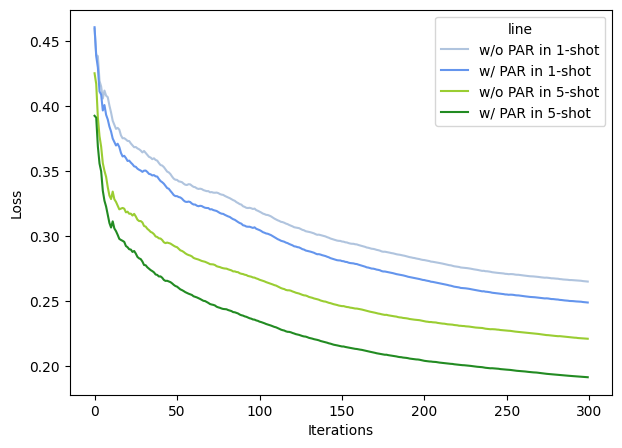

In [8]:
# @title Plotting losses
# @markdown **Note** that it assumes the files are located within drive.
# @markdown You can change the values if your runs are not saved on drive.
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def get_training_loss_figure ():

  plt.style.use("default")

  # 1-way, 1-shot; w/ PAR
  with open("/content/drive/MyDrive/PANet/Results/PANet_VOC_align_sets_0_1way_1shot_[train]/1/snapshots/query_losses_30000.pkl", 'rb') as f:
    _1way_1shot_losses_par = pickle.load(f)

  # 1-way, 1-shot; w/out PAR
  with open("/content/drive/MyDrive/PANet/Results/PANet_VOC_sets_0_1way_1shot_[train]/1/snapshots/query_losses_30000.pkl", 'rb') as f:
    _1way_1shot_losses = pickle.load(f)

  # 1-way, 5-shot; w/out PAR
  with open("/content/drive/MyDrive/PANet/Results/PANet_VOC_sets_0_1way_5shot_[train]/1/snapshots/query_losses_30000.pkl", 'rb') as f:
    _1way_5shot_losses = pickle.load(f)

  # 1-way, 5-shot; w/ PAR
  with open("/content/drive/MyDrive/PANet/Results/PANet_VOC_align_sets_0_1way_5shot_[train]/1/snapshots/query_losses_30000.pkl", 'rb') as f:
    _1way_5shot_losses_par = pickle.load(f)


  data = np.stack([
      np.array(_1way_1shot_losses),
      np.array(_1way_1shot_losses_par),
      np.array(_1way_5shot_losses),
      np.array(_1way_5shot_losses_par),
  ])

  columns = [
      'w/o PAR in 1-shot',
      'w/ PAR in 1-shot',
      'w/o PAR in 5-shot',
      'w/ PAR in 5-shot'
  ]

  colors = {
    'w/o PAR in 1-shot': 'lightsteelblue',
    'w/ PAR in 1-shot': 'cornflowerblue',
    'w/o PAR in 5-shot': 'yellowgreen',
    'w/ PAR in 5-shot': 'forestgreen'
  }

  df = pd.DataFrame(data.T, columns=columns)

  df["x"] = df.index
  df_melt = df.melt(id_vars="x", var_name="line", value_name="y")

  plt.figure(figsize=(7, 5))
  sns.lineplot(data=df_melt, x="x", y="y", hue="line", palette=colors)

  plt.gca().spines['top'].set_visible(True)
  plt.gca().spines['right'].set_visible(True)
  plt.gca().spines['left'].set_visible(True)
  plt.gca().spines['bottom'].set_visible(True)

  plt.ylabel("Loss")
  plt.xlabel("Iterations")

  return plt.gcf()

fig = get_training_loss_figure()
plt.show(fig)